# Malaria Detection - Kaggle Binary Image Classification Challenge
* This workbook illustrates my attempt to solve the [Kaggle Malaria Detection Challenge](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) using a Keras based CNN. I use Tensorflow's implementation of Keras (available in `tf.keras` package, so you don't have to additionally install the Keras library).
* This workbook also shows you how you can connect to Kaggle from a Colab Notebook and download dataset(s) for use locally.


<font color='firebrick'>It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>



<center><img src="https://drive.google.com/uc?id=1jqH-oLQ1JHxRAWIUK7ayNxPGa7VdvGHv"></center>

#### <font color='firebrick'>NOTE: This notebook can work on Google Colab as well as offline with a small change</font>
* When running this notebook on Google Colab, please set `USE_COLAB=True` in cell below,  else set `USE_COLAB=False`.
* `USE_COLAB=True` will setup access to Google Drive for the current user's login (assuming she has a Google ID). 
    * Your Google Drive gets mapped to `/content/drive/My Drive`, and your Notebooks get saved to `/content/drive/My Drive/Colab Notebooks/` folder in your Google Drive. 
    * Code will add `/content/drive/My Drive/Colab Notebooks/` folder to `system.path`. Save your custom Python code files `(*.py)` here, so they are automatically added to `system.path` and you can use them in your notebook. * 
* A `MODEL_STATES` global var is created to point to the _correct_ folder where the model's state (i.e. trained weights & biases) is stored to an `.h5` file.
    * If `USE_COLAB=True`, `MODEL_STATES` maps to `/content/drive/My Drive/Colab Notebooks/model_states` folder on Google Drive.
    * Else, `MODEL_STATES` maps to `./model_states` folder on your local disk (i.e a sub-folder of folder where notebook is saved)

In [0]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks")
    KERAS_NOTEBOOKS_PATH = os.path.join(colab_notebooks_path, "keras")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        print('You Keras Colab notebooks are available at ', COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(KERAS_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(KERAS_NOTEBOOKS_PATH))
        # and test it
        import kr_helper_funcs as kru
        MODEL_SAVE_DIR = os.path.join(KERAS_NOTEBOOKS_PATH, "model_states")
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/malaria"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Your Google Drive is mounted at  /content/drive/My Drive/
You Keras Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks
NOTE: /content/drive/My Drive/Colab Notebooks/keras is appended to sys.path!
MODEL_SAVE_DIR = /content/drive/My Drive/Colab Notebooks/keras/model_states


## Downloading the dataset from Kaggle
You can download datasets directly from Kaggle after running the following steps. This is helpful when you want to run code outside from Kaggle and try different algorithms for example. Following steps provide you access to Kaggle from within Colab, so you can download required datasets into a Colab environment.
* Login to your Kaggle a/c and _create a new API Token_ from your profile page (click the `Create API Token` button and download the `kaggle.json` file locally i.e. to your disk.
* Upload the `kaggle.json` that you downloaded to Colab  and move the file to `~/.kaggle/kaggle.json`
* Install Python packages `kaggle` and `kaggle-cli` that needed to access Kaggle programatically. These can be installed using `pip`
* Now you can access datasets on Kaggle
    * Run `!kaggle datasets list` shell command to list all available datasets (may no be such a useful command!)
    * Run `!datasets list -s <<dataset_name>>` to search for a dataset (e.g. for the Malaria dataset, I used `kaggle list -s malaria`)
    * Copy dataset locally using `!kaggle datasets download -d <<full_path_of_dataset>> -p <<target_folder_path>>`

**All the above commands are shell commands, hence start with a ! -- following cells have all the above commands (except the first). Run these one by one!!**

In [0]:
# assuming you downloaded kaggle.json file locally, run this cell to upload that file to Colab
# this sometimes causes problems, especially if I am behind a firewalls and uploads are jammed!
# from google.colab import files
# files.upload()

In [0]:
# so I uploaded my kaggle.json to my Google drive, which I can easily copy into Colab workspace :)
kaggle_json_path = os.path.join(COLAB_NOTEBOOKS_PATH, "kaggle.json")
assert os.path.exists(kaggle_json), "kaggle.json does not exist at %s" % kaggle_json_path

In [0]:
# Run this cell to move the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json rwx
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!cat ~/.kaggle/kaggle.json

kaggle.json
{"username":"mjbhobe","key":"3e759073242031b578fa32410ccd432a"}

In [0]:
# install Python packages require to access Kaggle datasets
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 5.3MB 6.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 112kB 36.8MB/s 
     |████████████████████████████████| 112kB 48.9MB/s 


In [0]:
# Vola! You now have access to Kaggle datasets

# list all datasets on Kaggle

#!kaggle datasets list

In [0]:
# look for our Malaria dataset like this 
# Search Command is: kaggle datasets list -s part_of_datafile_name)

#!kaggle datasets list -s malaria

The first one is the one we are looking for. Let's download the zip file to our `/tmp` folder

In [0]:
# download command: kaggle datasets download -d <<file_name>> -p <<dest>>

!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /tmp
!ls /tmp

 99% 670M/675M [00:14<00:00, 55.7MB/s]
100% 675M/675M [00:14<00:00, 49.1MB/s]
cell-images-for-detecting-malaria.zip  drivefs_ipc.0_shell
drivefs_ipc.0			       tmpzza0i8b9


In [0]:
# and let us unzip cell-images-for-detecting-malaria.zip to /tmp folder
import os, shutil
import zipfile

zip_file_path = '/tmp/cell-images-for-detecting-malaria.zip'
assert os.path.exists(zip_file_path)

# extract all files to /tmp
print('Source zip: %s' % zip_file_path)
print('Extracting all images...', end='', flush=True)
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()
print('done!', flush=True)

# now unhide the left panel in Colab, click the Files 'tab' & browse to /tmp folder
# you should see all your extracted images in 2 folders:
# /tmp/cell_images/Parasitized - images of infected files
# /tmp/cell_images/Uninfected - images of un-infected files

infected_files = os.listdir('/tmp/cell_images/Parasitized')
uninfected_files = os.listdir('/tmp/cell_images/Uninfected')

print('Downloaded %s infected and %d uninfected image files' % (len(infected_files), len(uninfected_files)))

Source zip: /tmp/cell-images-for-detecting-malaria.zip
Extracting all images...done!
Downloaded 13780 infected and 13780 uninfected image files


## About the Kaggle Dataset

The [Kaggle Malaria Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) contains 2 folders:
* Infected 
* Uninfected

And a total of 27,558 images.

**Acknowledgements**
This Dataset is taken from the official [NIH Website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/)

**Inspiration**
Save humans by detecting and deploying Image Cells that contain Malaria or not!

In [0]:
# if you want to use Tensorflow 2.0, run the following line
# You may have to re-set your runtime after installation & will be prompted to do so
#!pip install tensorflow==2.0.0

In [0]:
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import cv2
print('Using OpenCV version ', cv2.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
%matplotlib inline

USING_TF2 = (tf.__version__.startswith('2'))

import kr_helper_funcs as kru

plt.style.use('seaborn')
sns.set_style('darkgrid')

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=110)

seed = 123
random.seed(seed)
np.random.seed(seed)
if USING_TF2:
    tf.random.set_seed(seed)
else:
    tf.set_random_seed(seed)

Using Tensorflow version  1.15.0
Using OpenCV version  3.4.3


In [0]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 128, 128, 3
ADAM_LR_START, ADAM_WEIGHT_DECAY, LR_DECAY_RATE = 0.001, 1e-4, 0.001
NUM_EPOCHS, BATCH_SIZE = 100, 32

In [0]:
images_root = '/tmp/cell_images'

In [0]:
def load_image(image_path):
    # images are in different sizes - reduce to uniform size
    img = cv2.resize(cv2.imread(image_path),(IMAGE_HEIGHT, IMAGE_WIDTH))
    
    img = img.clip(0, 255).astype('uint8')
    # convert from BGR colorspace to RGB, so other libraries can process easily
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     img = img.clip(0, 255).astype('uint8')
#     image_yuv = cv2.cvtColor(img ,cv2.COLOR_BGR2YUV)
#     image_yuv[: ,: , 0] = cv2.equalizeHist(image_yuv[:,:,0])
#     img = cv2.cvtColor(image_yuv , cv2.COLOR_YUV2RGB)
    return img


print('Processing infected images...', flush=True, end='')
infected_images, infected_labels = [], []

infected_image_names = glob.glob("/tmp/cell_images/Parasitized/*.png")
for i in infected_image_names:
    img = load_image(i)
    infected_images.append(img)
    infected_labels.append(1)
    

infected_images = np.array(infected_images)
infected_labels = np.array(infected_labels)
print('\rInfected images: found %d images & %d labels' % (len(infected_images), len(infected_labels)))


print('Processing un-infected images...', flush=True, end='')

uninfected_images, uninfected_labels = [], []

uninfected_image_names = glob.glob("/tmp/cell_images/Uninfected/*.png")
for i in uninfected_image_names:
    img = load_image(i)
    uninfected_images.append(img)
    uninfected_labels.append(0)
    
uninfected_images = np.array(uninfected_images)
uninfected_labels = np.array(uninfected_labels)
print('\rUninfected images: found %d images & %d labels' % (len(uninfected_images), len(uninfected_labels)))

all_images = np.vstack([infected_images, uninfected_images])
all_labels = np.hstack([infected_labels, uninfected_labels])
print('All: found %d images & %d labels' % (len(all_images), len(all_labels)))

# delete these to conserve memory (as we'll be using pre-trained models)
del infected_images, infected_labels
del uninfected_images, uninfected_labels

Infected images: found 13779 images & 13779 labels
Uninfected images: found 13779 images & 13779 labels
All: found 27558 images & 27558 labels


In [0]:
# shuffle the data
indexes = np.random.permutation(np.arange(all_images.shape[0]))
#for _ in range(5): np.random.shuffle(indexes)

all_images = all_images[indexes]
all_labels = all_labels[indexes]
# I should see jumbled up 1 & 0's proving that labels (& hence images) are shuffled
print(all_labels[:25])

[1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0]


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(all_images, all_labels, test_size=0.20, random_state=seed)
test_images, test_labels = X_test.copy(), y_test.copy()
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_images.shape, test_labels.shape

((22046, 128, 128, 3),
 (22046,),
 (5512, 128, 128, 3),
 (5512,),
 (5512, 128, 128, 3),
 (5512,))

In [0]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    LABELS = {
        0: 'Uninfected',
        1: 'Infected',
    }
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.93)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                pil_image = Image.fromarray(sample_images[image_index])
                ax[r, c].imshow(pil_image, cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (LABELS[true_label], LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

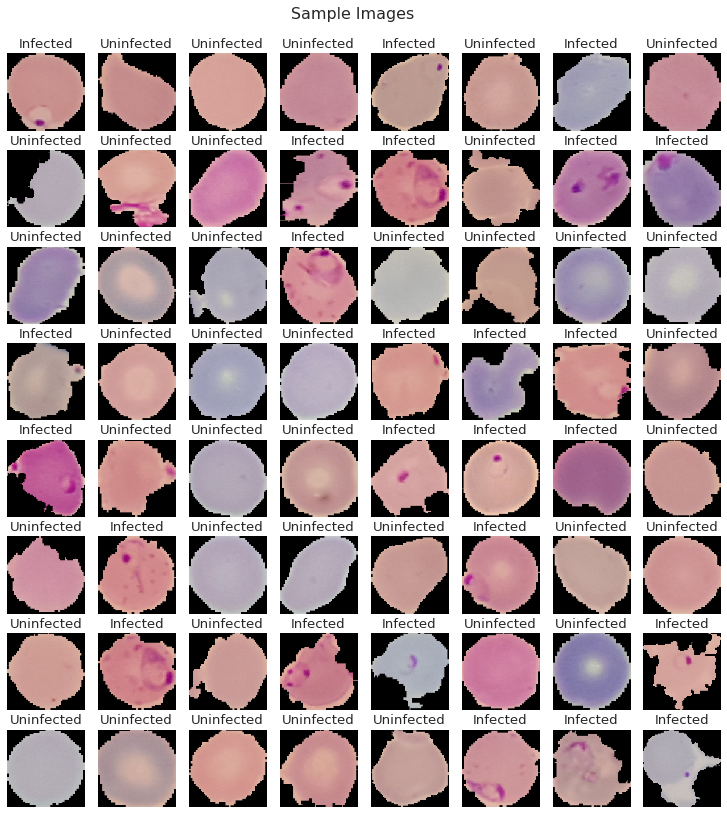

In [0]:
# display a random sample of images & labels
sample_size = 64
rand_indexes = np.random.choice(np.arange(len(test_images)), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
#sample_images.shape, sample_labels.shape, len(sample_images), len(sample_labels)
display_sample(sample_images, sample_labels, plot_title="Sample Images", 
               num_rows=8, num_cols=8, fig_size=(13,13))

In [0]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


## Using VGG19 Pre-trained Model

VGG19 is a popular pre-trained model for image classification. It is a layered model and simple to understand. In this section, we will download weights of the VGG19 model and "chop off" the upper Dense layers. In an image classifier, the Conv2D layers are the ones that learn the edges, boundaries and patterns in the image, which is what I want to keep. The Dense layers generate the predictions from the detected patterns - so I'll want to replace these with my own layers (hence the dropping-off of the Dense layers).

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()  # tf.reset_default_graph()

# NOTE: will download the weights for imagenet
vgg16_base = VGG16(
    weights='imagenet',    # use weights for ImageNet
    include_top=False,     # don't use upper Dense layers
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg16_base.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128

In [0]:
def build_model_xfer(use_l2_loss=True):
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.regularizers import l2
    
    l2_loss_lambda = 0.00002  # just a wee-bit :)
    l2_loss = l2(l2_loss_lambda) if use_l2_loss else None
    if l2_loss is not None: print('Using l2_loss_lambda = %f' % l2_loss_lambda)
        
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # mark mobilenet layer as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg16_base.trainable = False
    
    model.compile(optimizer=Adam(lr=ADAM_LR_START), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
try:
    del model
except NameError:
    pass # model is not defined!

model = build_model_xfer()
print(model.summary())

Using l2_loss_lambda = 0.000020
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800 

In [0]:
# train the model
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_step(epoch):
    power = (epoch % 20) # [0-19] = 0, [20-39] = 1, [40-59] = 2...
    new_lr = ADAM_LR_START * 1.0 / (1 + ADAM_LR_DECAY * power)
    return new_lr

lr_callback = LearningRateScheduler(lr_step)

hist = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_split=0.20)
                 #callbacks=[lr_callback])

Train on 17636 samples, validate on 4410 samples
Epoch 1/50
17632/17636 [============================>.] - ETA: 0s - loss: 0.3208 - acc: 0.8837

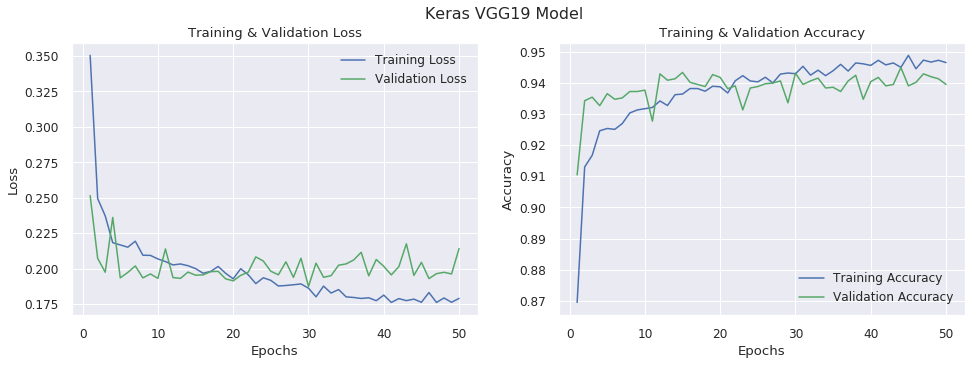

In [0]:
kru.show_plots(hist.history, "Keras VGG19 Model")

In [0]:
# evaluate performance on train & test data
loss, acc = model.evaluate(X_train, y_train, batch_size=64, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

22046/22046 [==============================] - 66s 3ms/sample - loss: 0.1467 - acc: 0.9638
Training data  -> loss: 0.147, acc: 0.964
5512/5512 [==============================] - 16s 3ms/sample - loss: 0.2077 - acc: 0.9399
Testing data   -> loss: 0.208, acc: 0.940


In [0]:
kru.save_keras_model(model, "kr_malaria_vgg16", MODEL_SAVE_DIR)
del model

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_malaria_vgg16.h5


In [0]:
model = kru.load_keras_model("kr_malaria_vgg16", MODEL_SAVE_DIR)
print(model.summary())

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_malaria_vgg16.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________

In [0]:
y_pred = (model.predict(X_test, batch_size=BATCH_SIZE) >= 0.5).ravel().astype('int32')
print('Actuals    : ', y_test[:30])
print('Predictions: ', y_pred[:30])
print('We got %d of %d wrong!' % ((y_pred != y_test).sum(), len(y_test)))

Actuals    :  [1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0]
Predictions:  [1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1]
We got 331 of 5512 wrong!


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2729
           1       0.93      0.95      0.94      2783

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512

[[2542  187]
 [ 144 2639]]


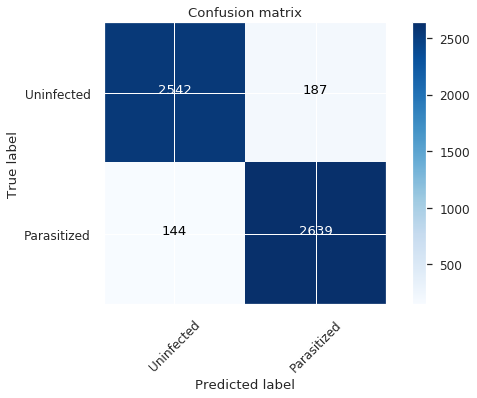

In [0]:
# let's see the confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
kru.plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=["Uninfected","Parasitized"])

**Observations:**

>Configuration | Training Acc | Test Acc | Incorrect Predictions | Precision | Recall | F1-Score
>:---|:---:|:---:|:---:|:---:|:---:|:---:|
>**VGG16 Base Model**|96-97%|94-95%|331|0.95|0.93|0.94

* From the loss and accuracy curves, we see that the cross-validation loss & accuracy follows the training loss & accuracy curves after the 20 epoch - there is some diversion
* From the accuracy metrics, we can conclude that the model is overfitting the data slightly (2% difference between training & test accuracies).

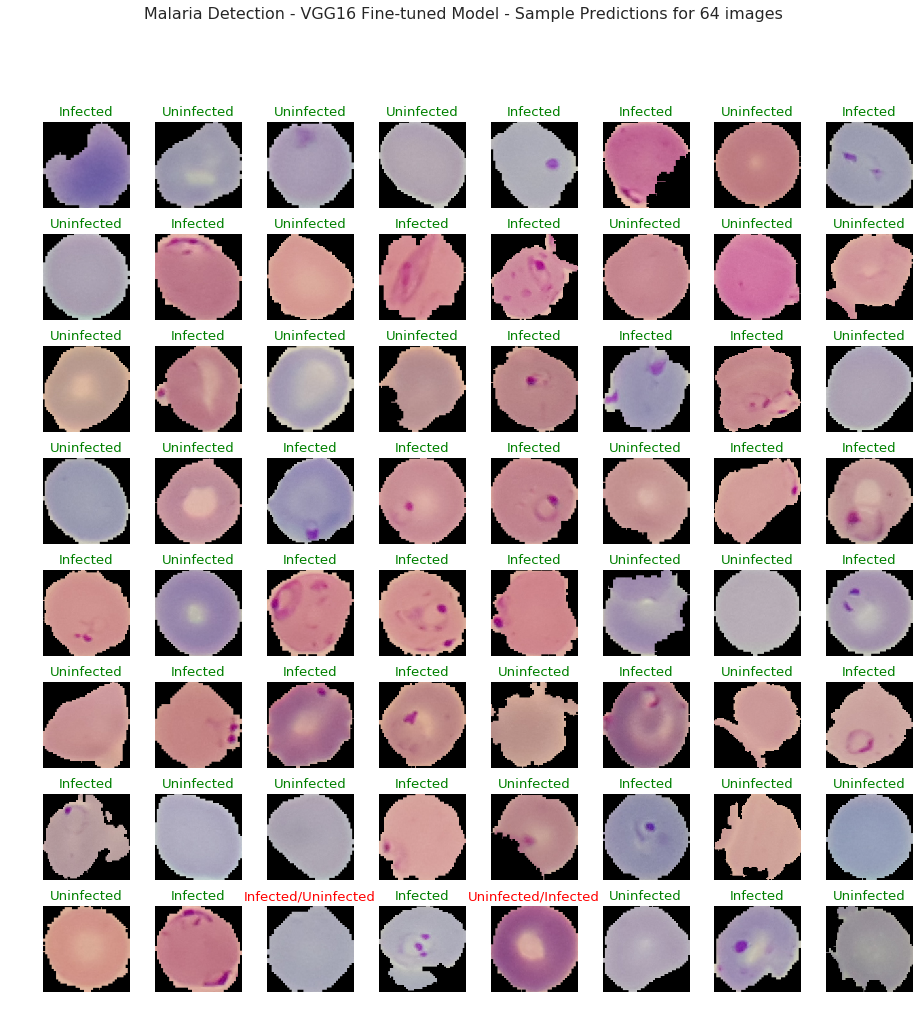

In [0]:
# display a random sample of 64 images from test_images/test_labels set with predictions
sample_size = 64
rand_indexes = np.random.choice(np.arange(len(test_images)), sample_size)
rand_images = test_images[rand_indexes]
rand_labels = test_labels[rand_indexes]
rand_predictions = y_pred[rand_indexes]
#sample_images.shape, sample_labels.shape, len(sample_images), len(sample_labels)
display_sample(rand_images, rand_labels, sample_predictions=rand_predictions,
               plot_title='Malaria Detection - VGG16 Fine-tuned Model - Sample Predictions for %d images' % sample_size, 
               num_rows=8, num_cols=8, fig_size=(16,16))

In [0]:
del vgg16_base
del model

## Fine Tuning the VGG16 Model

In this section we'll fine tune the baseVGG16 model (i.e. rather than freezing all layers, we'll train the last conv2d layer along with our images). This will, hopefully, further improve accuracy of model.





In [0]:
try:
    del vgg16_base_ft
except NameError:
    pass # model is not defined!    

try:
    del model
except NameError:
    pass # model is not defined!

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()  # tf.reset_default_graph()

# NOTE: will download the weights for imagenet
vgg16_base_ft = VGG16(
    weights='imagenet',    # use weights for ImageNet
    include_top=False,     # don't use upper Dense layers
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg16_base_ft.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
# now let's unlock the last conv2d layer - from block_conv3 upwards
# (i.e. block5_conv3 and block5_pool, though the pooling layer has no trainable params!)

trainable = False

for layer in vgg16_base_ft.layers:
    if layer.name == 'block5_conv3':
        trainable = True
    # will set to False until we hit the "block5_conv2" layer    
    layer.trainable = trainable

for layer in vgg16_base_ft.layers:
    print('%s - trainable? %s' % (layer.name, layer.trainable))

input_1 - trainable? False
block1_conv1 - trainable? False
block1_conv2 - trainable? False
block1_pool - trainable? False
block2_conv1 - trainable? False
block2_conv2 - trainable? False
block2_pool - trainable? False
block3_conv1 - trainable? False
block3_conv2 - trainable? False
block3_conv3 - trainable? False
block3_pool - trainable? False
block4_conv1 - trainable? False
block4_conv2 - trainable? False
block4_conv3 - trainable? False
block4_pool - trainable? False
block5_conv1 - trainable? False
block5_conv2 - trainable? False
block5_conv3 - trainable? True
block5_pool - trainable? True


In [0]:
print(vgg16_base_ft.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
# now let's build our model
def build_model_xfer2(use_l2_loss=True):
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.regularizers import l2
    
    l2_loss_lambda = 0.00010  # just a "pinch" of L2 regularization :)
    l2_loss = l2(l2_loss_lambda) if use_l2_loss else None
    if l2_loss is not None: print('Using l2_loss_lambda = %f' % l2_loss_lambda)
        
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base_ft,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.30),        
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.20),     
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),           
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # NOTE: we do not freeze vgg_base entirely as done previously!!
    
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
model_xfer2 = build_model_xfer2()
print(model_xfer2.summary())

Using l2_loss_lambda = 0.000100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)     

In [0]:
# train the model - training for 100 epochs
hist = model_xfer2.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_split=0.20)

Train on 17636 samples, validate on 4410 samples
Epoch 1/50
17636/17636 [==============================] - 75s 4ms/sample - loss: 0.3803 - acc: 0.9184 - val_loss: 0.2937 - val_acc: 0.9422
Epoch 2/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.2561 - acc: 0.9422 - val_loss: 0.2014 - val_acc: 0.9510
Epoch 3/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.2072 - acc: 0.9490 - val_loss: 0.1902 - val_acc: 0.9556
Epoch 4/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.1865 - acc: 0.9476 - val_loss: 0.1670 - val_acc: 0.9481
Epoch 5/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.1682 - acc: 0.9515 - val_loss: 0.1635 - val_acc: 0.9546
Epoch 6/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.1605 - acc: 0.9532 - val_loss: 0.1589 - val_acc: 0.9535
Epoch 7/50
17636/17636 [==============================] - 74s 4ms/sample - loss: 0.1506 - acc: 0.9544 - val_loss: 0.1

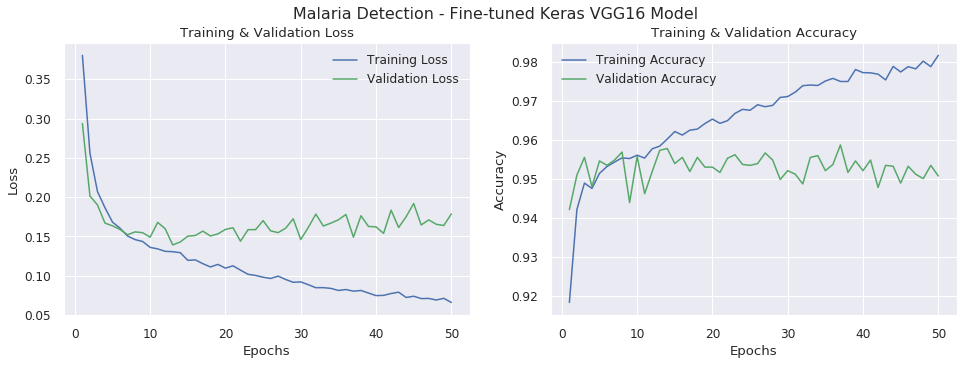

In [0]:
kru.show_plots(hist.history, "Malaria Detection - Fine-tuned Keras VGG16 Model")

In [0]:
# evaluate performance on train & test data
loss, acc = model_xfer2.evaluate(X_train, y_train, batch_size=64, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

22046/22046 [==============================] - 66s 3ms/sample - loss: 0.0697 - acc: 0.9815
Training data  -> loss: 0.070, acc: 0.982
5512/5512 [==============================] - 16s 3ms/sample - loss: 0.1926 - acc: 0.9514
Testing data   -> loss: 0.193, acc: 0.951


In [0]:
kru.save_keras_model(model_xfer2, "kr_malaria_vgg16_ft", MODEL_SAVE_DIR)
del model_xfer2

Saved model to file /content/drive/My Drive/Colab Notebooks/model_states/kr_malaria_vgg16_ft.h5


In [0]:
model_xfer2 = kru.load_keras_model("kr_malaria_vgg16_ft", MODEL_SAVE_DIR)
print(model_xfer2.summary())

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/model_states/kr_malaria_vgg16_ft.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
______________________

In [0]:
y_pred = (model_xfer2.predict(X_test, batch_size=BATCH_SIZE) >= 0.5).ravel().astype('int32')
print('Actuals    : ', y_test[:30])
print('Predictions: ', y_pred[:30])
print('We got %d of %d wrong!' % ((y_pred != y_test).sum(), len(y_test)))

Actuals    :  [1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0]
Predictions:  [1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1]
We got 268 of 5512 wrong!


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2729
           1       0.95      0.96      0.95      2783

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

[[2586  143]
 [ 125 2658]]


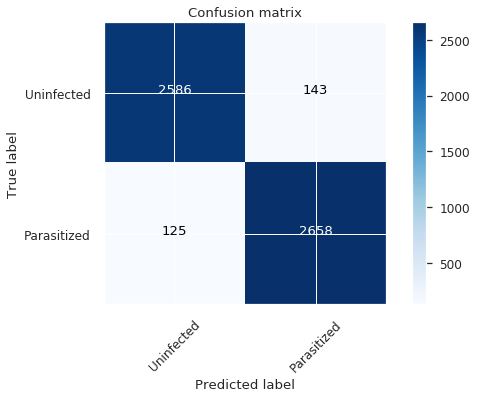

In [0]:
# let's see the confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
kru.plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=["Uninfected","Parasitized"])

**Observations:**

>Configuration | Training Acc | Test Acc | Incorrect Predictions | Precision | Recall | F1-Score
>:---|:---:|:---:|:---:|:---:|:---:|:---:|
>**VGG16 Base Model**|96-97%|94-95%|331|0.95|0.93|0.94
>**VGG16 Fine Tuned**|98-99%|95-96%|250|0.95|0.96|0.95

* Though the metrics look good, this is stillan overfitting model. We should look at increasing the regularization.
* Notice that the incidence of False Positives (predicting +ve, when actual uninfected) have come down to 143 from 187, and False negatives (predicting not infected, when infected) have also come down (125 vs 144), making this a better classifier.

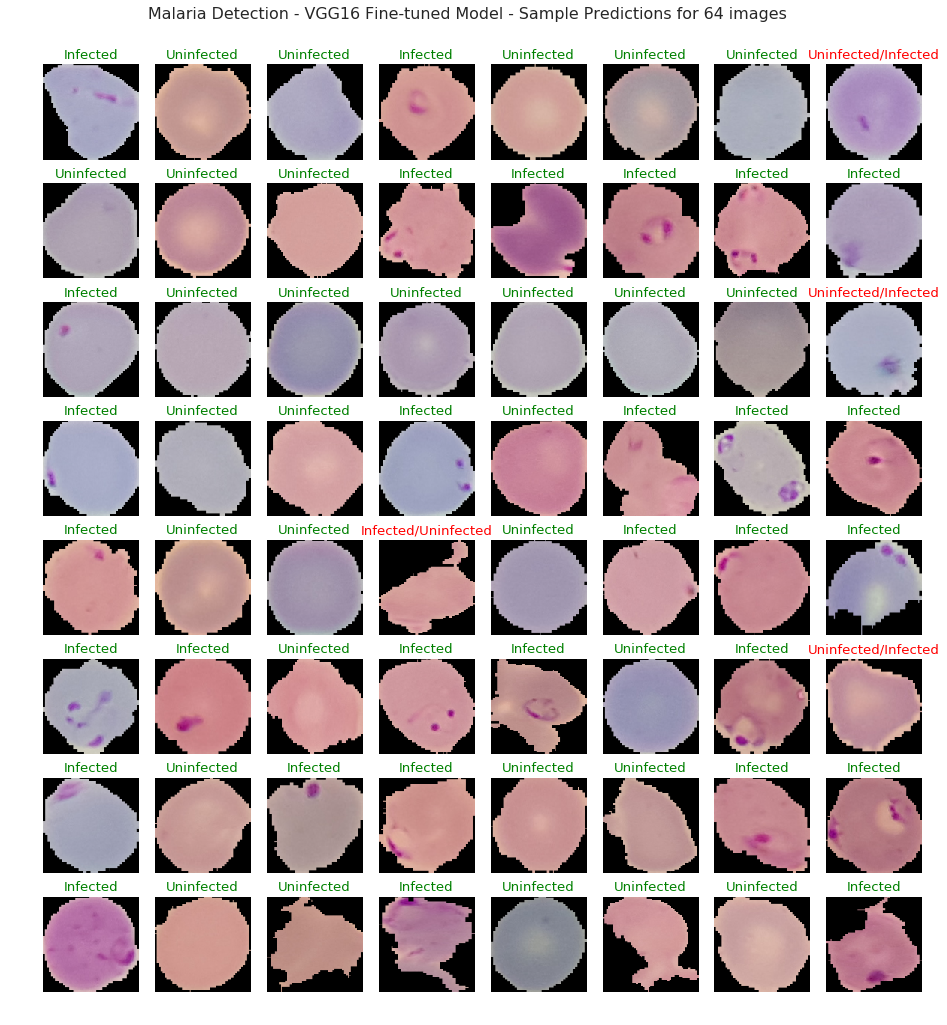

In [0]:
# display a random sample of 64 images from test_images/test_labels set with predictions
sample_size = 64
rand_indexes = np.random.choice(np.arange(len(test_images)), sample_size)
rand_images = test_images[rand_indexes]
rand_labels = test_labels[rand_indexes]
rand_predictions = y_pred[rand_indexes]
#sample_images.shape, sample_labels.shape, len(sample_images), len(sample_labels)
display_sample(rand_images, rand_labels, sample_predictions=rand_predictions,
               plot_title='Malaria Detection - VGG16 Fine-tuned Model - Sample Predictions for %d images' % sample_size, 
               num_rows=8, num_cols=8, fig_size=(16,16))

In [0]:
del vgg16_base_ft
del model_xfer2

# <center>---- END ----</center>